### Import Torch

In [167]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Download MNIST dataset

In [168]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = './data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = './data', 
    train = False, 
    transform = ToTensor()
)

### Visualize MNIST dataset

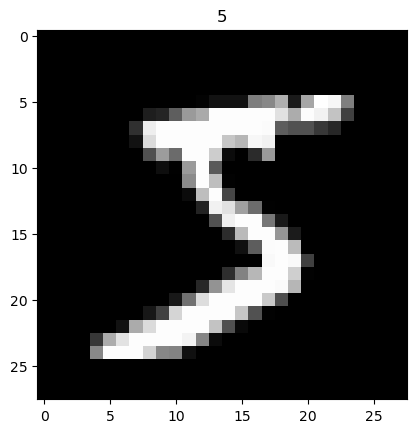

In [169]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

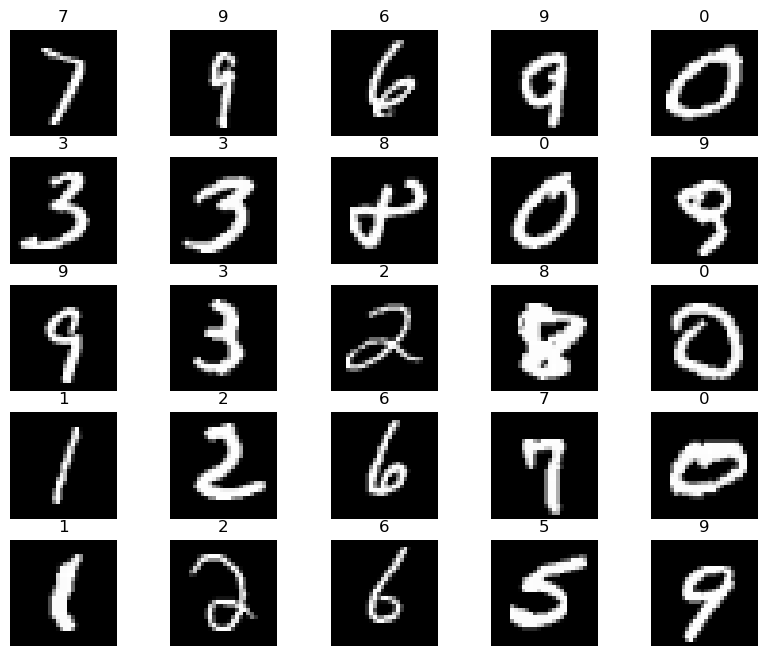

In [170]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Split the training dataset into training and validation datasets

In [171]:
from sklearn.model_selection import train_test_split

# your code here
train_data, val_data = train_test_split(train_data, test_size = 0.1, random_state = 123, shuffle = True)
train_data[0][0].size()


torch.Size([1, 28, 28])

### Prepare for the datasets using dataloader

In [172]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    'val'  : torch.utils.data.DataLoader(val_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
}

### Import nn module from torch

In [173]:
from torch import nn
import torch.nn.functional as F

### Set hyperparameters

In [174]:
# Set hyperparameters before building the model
sequence_length = 28
# We treat each row of pixels in the image as a time step. so 28(=row)
input_size = 28 # 28(=col?)
hidden_size = 128 #The number of features in the hidden state.
num_layers = 2 # The number of recurrent layers.
num_classes = 10
batch_size = 100
num_epochs = 5
learning_rate = 0.01 

### Build a LSTM model for sequence classification task

In [175]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        # your code here
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.l = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # your code here
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        #(num_layers, batch_size, hidden_size) 크기의 initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0) , self.hidden_size)
        #(num_layers, batch_size, hidden_size) 크기의 initial cell state
        x, _ = self.lstm(x, (h0, c0))
        #nn.LSTM 반환값은 output, (final hidden state, final cell state)
        x = x[:, -1, :] #제일 마지막 hidden_state 추출.
        #[100(batch),28(sequence),128(hidden)] -> [100,128]
        x = self.l(x)
        return x

        # Set initial hidden and cell states         
        # Pass in the input and hidden state into the model and obtaining outputs
        # Reshape the outputs such that it can be fitted into the fully connected layer

       
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

LSTM(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (l): Linear(in_features=128, out_features=10, bias=True)
)


### Set a loss function

In [176]:
loss_func = nn.CrossEntropyLoss()  # your code here

### Set an optimizer

In [177]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # your code here 

### Train the LSTM model

In [178]:
def train(num_epochs, model, loaders):
        
    total_step = len(loaders['train']) # total step: total number of batches
    
    for epoch in range(num_epochs):
        # Train the model
        # your code here
        total_loss = 0
        for image, label in loaders['train']: #batch 하나에 숫자 100개
            image = image.reshape(-1, 28, 28) #공부
            #[100,1,28,28] -> [100,28,28]
            output = model(image)
            loss = loss_func(output, label)
            total_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("total_loss =", total_loss)
                
        # Validate the model
        # your code here
        with torch.no_grad():
            total_right = 0
            for image, label in loaders['val']:
                image = image.reshape(-1, 28, 28) #공부
                output = model(image)
                right = (output.max(1)[1] == label).sum()
                total_right += right
            print(total_right / len(loaders['val'].dataset))


train(num_epochs, model, loaders)

total_loss = tensor(238.3412, grad_fn=<AddBackward0>)
tensor(0.9670)
total_loss = tensor(61.3281, grad_fn=<AddBackward0>)
tensor(0.9688)
total_loss = tensor(44.0944, grad_fn=<AddBackward0>)
tensor(0.9760)
total_loss = tensor(37.3784, grad_fn=<AddBackward0>)
tensor(0.9762)
total_loss = tensor(34.7403, grad_fn=<AddBackward0>)
tensor(0.9782)


### Evaluate the trained LSTM model (compute accuracy on the test dataset)

In [179]:
# Test the model
# your code here
with torch.no_grad():
    total_right = 0
    for image, label in loaders['test']:
        image = image.reshape(-1, 28, 28)
        output = model(image)
        label = label.to(device)
        right = (output.max(1)[1] == label).sum()
        total_right += right
    print(f"average accuracy : {total_right/len(loaders['test'].dataset)}")


average accuracy : 0.9815999865531921


### Show the results with randomly selected 10 samples from the test data

In [180]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
imgs = imgs
lbls = lbls
test_output = model(imgs[:10].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
labels = lbls[:10].cpu().numpy()
print(f"Predicted number: {predicted}")
print(f"Actual number:    {labels}")

Predicted number: [7 2 1 0 4 1 4 9 5 9]
Actual number:    [7 2 1 0 4 1 4 9 5 9]
